# Train a JointVAE model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to your device

### Load The Shoe Data

In [8]:
!ls /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/

0  8			      archive2_2.tar.bz2  mltmp.tar.bz2
1  9			      archive2_3.tar.bz2  __pycache__
2  anchor_positive_data.json  archive2_4.tar.bz2  rayimages2_cleaned.h5
3  archive1_5.tar.bz2	      archive6.tar.bz2	  rayimages2.h5
4  archive1_8.tar.bz2	      archive7.tar.bz2	  README.txt
5  archive1_9.tar.bz2	      clean_data.pkl	  selectMetaData9.sql
6  archive2_0.tar.bz2	      data_loader.py
7  archive2_1.tar.bz2	      da.tar.bz2


In [9]:
import pandas as pd
metadata = pd.read_hdf("/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/rayimages2_cleaned.h5")

In [10]:
metadata.head(3)

,PRODUCT_ID,PRODUCT_COLORWAY_ID,COLORWAY_IMAGE_ROLE_TYPE,IMAGE_ID,PRODUCT_TYPE,SIZE_RANGE,GENDER
IMAGE_FILE,,,,,,,
2/8/2878730_3748135.jpg,2878730,2464687,CPRI,3748135,BEAUTY_TOOL,Regular,Unisex
2/8/2878730_3783475.jpg,2878730,2464687,CADD,3783475,BEAUTY_TOOL,Regular,Unisex
1/5/1506322_2880153.jpg,1506322,1416673,CPRI,2880153,APPAREL,Regular,Men


In [21]:
#np.unique(metadata['PRODUCT_TYPE'])

In [13]:
shoe_types = ['SHOE', 'BOAT_SHOE', 'OXFORDS', 'PUMP', 'SLIPPER', 'SNEAKER', 'SANDAL']

In [16]:
shoe_df = metadata.query("PRODUCT_TYPE in ['SHOE', 'BOAT_SHOE', 'OXFORDS', 'PUMP', 'SLIPPER', 'SNEAKER', 'SANDAL']")

In [18]:
shoe_df.PRODUCT_TYPE.unique()

array(['SHOE', 'SNEAKER', 'SANDAL', 'SLIPPER', 'PUMP', 'OXFORDS',
       'BOAT_SHOE'], dtype=object)

In [20]:
shoe_df['PRODUCT_TYPE'].value_counts()

SHOE         384261
SANDAL        76526
SNEAKER       41403
PUMP          36571
OXFORDS        5411
SLIPPER        2185
BOAT_SHOE      1702
Name: PRODUCT_TYPE, dtype: int64

In [25]:
image_dir = '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/'
shoe_paths = [image_dir + str(x) for x in shoe_df.index]
shoe_paths[:5]

['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/8/5860413_9882517.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/8/5814376_9882308.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/8/5814376_9882313.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/5/6571113_9877407.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/5/6571113_9877409.jpg']

In [27]:
from random import shuffle
shuffle(shoe_paths)
shoe_paths[:5]

['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/4/5490868_9146909.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/2/2282153_2773594.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/772170_1411508.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/6/5627645_9209479.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/2/5276330_9050994.jpg']

In [28]:
len(shoe_paths)

548059

In [48]:
bad_shoe_data = [
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/2/1230829_1895083.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753691_1364774.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363403.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/4/740051_1331707.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780525_1365250.jpg,'
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363417.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753697_1364807.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769984_1401921.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/772230_1463582.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/6/1623718_1461437.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780384_1438452.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753693_1364782.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769985_1401928.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/779788_1446011.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363407.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363395.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769983_1401914.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/777997_1427453.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/751112_1359521.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363403.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/4/747952_1351249.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/790670_1461437.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363409.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2744495_1461437.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753693_1364780.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/9/295482_1336219.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985868_1336219.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/1/812996_1331707.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1058184_1446011.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/799491_1468948.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363407.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985868_1336221.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/3/835585_1336219.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/9/295482_1336221.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/3/1376460_1401921.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/750666_1362453.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753700_1364821.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793509_1462001.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469682.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/774841_1417904.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/777900_1428744.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2744495_1461436.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363397.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/775985_1429262.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/791665_1469695.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/5131012_1461437.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363393.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/772391_1410997.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798046_1469791.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780384_1438454.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769585_1399069.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769984_1461991.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2751336_1336221.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363397.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/7/672968_1365250.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363405.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/8/1872331_1336221.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363417.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/791664_1469683.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363401.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/770392_1404858.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363393.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753691_1364773.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363415.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469683.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/777997_1427452.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793509_1462003.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363415.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/791664_1469680.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/2/1230778_1894683.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798046_1469792.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/2/1230808_1894813.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753758_1363403.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780533_1384839.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363417.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363405.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363409.jpg',
    '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/770392_1404858.jpg',
]

In [49]:
for pth in shoe_paths:
    if pth in bad_shoe_data:
        del shoe_paths[shoe_paths.index(pth)]
        
print(len(shoe_paths))

547971


In [50]:
image_paths_train = shoe_paths[:470000]
image_paths_test = shoe_paths[470000:-71]

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 470,000
Number of test image paths: 77,900

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/4/5490868_9146909.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/0/5017735_8798731.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/2/623559_657059.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/3/5368629_9365234.jpg


### Create data loaders

In [51]:
from torchvision import transforms
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 200

composed = transforms.Compose([transforms.CenterCrop((256,256)),transforms.Resize((256,256)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=256, transform=composed, 
                                 convert_rgb=False, error_handling=True)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=256, transform=composed, 
                                convert_rgb=False, error_handling=True)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [52]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 20, 'disc': [10, 10, 10]}

### Build a model

In [53]:
from jointvae.models_256_convjump2bn import VAE

model = VAE(latent_spec=latent_spec, hidden_dim=512, img_size=(3, 256, 256), use_cuda=use_cuda)

In [54]:
#print(model)

### Train the model

In [55]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=8e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [56]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 6, 35000, 36.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 6, 35000, 36.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [57]:
#from viz.visualize import Visualizer
from viz.visualize import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [ ]:
# Note this should be at least 100 epochs for proper training or more but can be less to demo

trainer.train(train_loader, epochs=57, save_training_gif=None)

0/470000	Loss: 45220.672
10000/470000	Loss: 39426.858
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/5131012_1461435.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793850_1463528.jpg does not have 3 channels
Replacing with previous image
20000/470000	Loss: 25955.476
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798050_1469769.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/1/1158562_1469680.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2440039_1401921.jpg does not have 3 channels
Replacing with previous image
30000/470000	Loss: 17867.921
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798045_1469808.jpg does not have 3 channels
Replacing with previous image
40000/470000	Loss: 16

file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363413.jpg does not have 3 channels
Replacing with previous image
60000/470000	Loss: 13475.468
70000/470000	Loss: 13404.214
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469683.jpg does not have 3 channels
Replacing with previous image
80000/470000	Loss: 13464.571
90000/470000	Loss: 13378.752
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/6/1623718_1461435.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469680.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780384_1438455.jpg does not have 3 channels
Replacing with previous image
100000/470000	Loss: 13488.618
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2440039_1401921.jpg does not have 3 channels
Replacing with pre

110000/470000	Loss: 13294.865
120000/470000	Loss: 13293.781
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/799464_1468942.jpg does not have 3 channels
Replacing with previous image
130000/470000	Loss: 13216.574
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/5131012_1461436.jpg does not have 3 channels
Replacing with previous image
140000/470000	Loss: 13181.481
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769983_1401916.jpg does not have 3 channels
Replacing with previous image
150000/470000	Loss: 13260.106
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/790670_1461435.jpg does not have 3 channels
Replacing with previous image
160000/470000	Loss: 13207.058
170000/470000	Loss: 13252.981
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/4/747953_1351254.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5

file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
130000/470000	Loss: 13090.249
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753700_1364823.jpg does not have 3 channels
Replacing with previous image
140000/470000	Loss: 13094.002
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798050_1469769.jpg does not have 3 channels
Replacing with previous image
150000/470000	Loss: 13138.016
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/3/1365642_1446011.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798043_1469808.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363411.jpg does not have 3 channels
Replacing with previous image
160000/470000	Loss: 13144.695
file /home/jov

file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/766080_1394360.jpg does not have 3 channels
Replacing with previous image
130000/470000	Loss: 13052.379
140000/470000	Loss: 13026.988
150000/470000	Loss: 13000.508
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/6/1639507_1446011.jpg does not have 3 channels
Replacing with previous image
160000/470000	Loss: 12918.044
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769585_1399068.jpg does not have 3 channels
Replacing with previous image
170000/470000	Loss: 12986.560
180000/470000	Loss: 13056.173
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753700_1364823.jpg does not have 3 channels
Replacing with previous image
190000/470000	Loss: 13012.149
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793850_1463528.jpg does not have 3 channels
Replacing with previous image
200000/470000	Loss: 13024.522
210000/470000	Loss: 13025.777
220000/47

240000/470000	Loss: 12861.964
250000/470000	Loss: 12908.872
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363411.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469683.jpg does not have 3 channels
Replacing with previous image
260000/470000	Loss: 13023.268
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/5/858397_1364773.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/6/1639507_1446011.jpg does not have 3 channels
Replacing with previous image
270000/470000	Loss: 12919.726
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798050_1469769.jpg does not have 3 channels
Replacing with previous image
280000/470000	Loss: 12978.580
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/791664_1469682.jpg does not have 3 channels
Replacing with 

280000/470000	Loss: 12847.040
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798050_1469769.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
290000/470000	Loss: 12845.717
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/3/1365642_1446011.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/784292_1444176.jpg does not have 3 channels
Replacing with previous image
300000/470000	Loss: 12843.597
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469683.jpg does not have 3 channels
Replacing with previous image
310000/470000	Loss: 12861.007
320000/470000	Loss: 12941.403
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/5/858397_1364773.jpg does not have 3 channels
Replacing with

file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2440039_1461991.jpg does not have 3 channels
Replacing with previous image
240000/470000	Loss: 12722.320
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469683.jpg does not have 3 channels
Replacing with previous image
250000/470000	Loss: 12898.085
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/756167_1371041.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363411.jpg does not have 3 channels
Replacing with previous image
260000/470000	Loss: 12805.402
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753700_1364823.jpg does not have 3 channels
Replacing with previous image
270000/470000	Loss: 12874.983
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798043_1469808.jpg does not have 3 channels
Replacing with previous image
280000/470000	L

370000/470000	Loss: 12808.812
380000/470000	Loss: 12758.922
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469680.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/5131012_1461435.jpg does not have 3 channels
Replacing with previous image
390000/470000	Loss: 12739.551
400000/470000	Loss: 12711.891
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769585_1399068.jpg does not have 3 channels
Replacing with previous image
410000/470000	Loss: 12773.794
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363413.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793850_1463528.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798043_1469808.jpg does not have 3 channels
Replacing with 

390000/470000	Loss: 12710.611
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/1/1158562_1469680.jpg does not have 3 channels
Replacing with previous image
400000/470000	Loss: 12681.926
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/773083_1420891.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/777994_1427442.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769983_1401916.jpg does not have 3 channels
Replacing with previous image
410000/470000	Loss: 12754.965
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798045_1469808.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v2

410000/470000	Loss: 12625.759
420000/470000	Loss: 12662.023
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/756167_1371041.jpg does not have 3 channels
Replacing with previous image
430000/470000	Loss: 12611.896
440000/470000	Loss: 12615.730
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753693_1364783.jpg does not have 3 channels
Replacing with previous image
450000/470000	Loss: 12657.333
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363411.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769585_1399068.jpg does not have 3 channels
Replacing with previous image
460000/470000	Loss: 12676.125
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363411.jpg does not have 3 channels
Replacing with previous image
Epoch: 11 Average loss: 12681.74
0/470000	Loss: 12400.562
10000/470000	Loss: 12640.508
20000/470000	

file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769983_1401916.jpg does not have 3 channels
Replacing with previous image
460000/470000	Loss: 12756.941
Epoch: 12 Average loss: 12644.18
0/470000	Loss: 12745.382
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/764859_1401869.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769585_1399068.jpg does not have 3 channels
Replacing with previous image
10000/470000	Loss: 12640.331
20000/470000	Loss: 12642.910
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780384_1438455.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/768641_1428386.jpg does not have 3 channels
Replacing with prev

20000/470000	Loss: 12649.692
30000/470000	Loss: 12526.181
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/4/747953_1351254.jpg does not have 3 channels
Replacing with previous image
40000/470000	Loss: 12628.222
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2440039_1461991.jpg does not have 3 channels
Replacing with previous image
50000/470000	Loss: 12556.382
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/9/698058_1384839.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/773083_1420891.jpg does not have 3 channels
Replacing with previous image
60000/470000	Loss: 12596.201
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363413.jpg does not have 3 channels
Replacing with previous image
70000/470000	Loss: 12519.441
80000/470000	Loss: 12580.897
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/513101

110000/470000	Loss: 12432.704
120000/470000	Loss: 12539.541
130000/470000	Loss: 12571.357
140000/470000	Loss: 12617.354
150000/470000	Loss: 12643.821
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/777994_1427442.jpg does not have 3 channels
Replacing with previous image
160000/470000	Loss: 12614.351
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/9/8/985912_1469680.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/779190_1451050.jpg does not have 3 channels
Replacing with previous image
170000/470000	Loss: 12645.170
180000/470000	Loss: 12558.896
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/785954_1451084.jpg does not have 3 channels
Replacing with previous image
190000/470000	Loss: 12545.283
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/769639_1399528.jpg does not have 3 channels
Replacing with previous image
file /home

160000/470000	Loss: 12615.659
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/799464_1468942.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
170000/470000	Loss: 12573.596
180000/470000	Loss: 12583.228
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/8/3/835585_1336221.jpg does not have 3 channels
Replacing with previous image
190000/470000	Loss: 12497.469
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/3/1376460_1461991.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/6/1623718_1461435.jpg does not have 3 channels
Replacing with previous image
200000/470000	Loss: 12593.356
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/7/779190_1451050.jpg does not have 3 channels
Replacing wit

150000/470000	Loss: 12486.434
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/4/747953_1351254.jpg does not have 3 channels
Replacing with previous image
160000/470000	Loss: 12594.953
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/756167_1371041.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/798050_1469769.jpg does not have 3 channels
Replacing with previous image
170000/470000	Loss: 12539.533
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363413.jpg does not have 3 channels
Replacing with previous image
180000/470000	Loss: 12495.073
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/6/764859_1401869.jpg does not have 3 channels
Replacing with previous image
190000/470000	Loss: 12509.867
200000/470000	Loss: 12474.238
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/9/793850_1463528.jpg does not ha

180000/470000	Loss: 12518.657
190000/470000	Loss: 12553.753
200000/470000	Loss: 12520.347
210000/470000	Loss: 12567.163
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/1/0/1096090_1469682.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/1/5131012_1461435.jpg does not have 3 channels
Replacing with previous image
220000/470000	Loss: 12534.466
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/9/698058_1384839.jpg does not have 3 channels
Replacing with previous image
230000/470000	Loss: 12575.523
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/8/780384_1438455.jpg does not have 3 channels
Replacing with previous image
240000/470000	Loss: 12559.686
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/5/753759_1363413.jpg does not have 3 channels
Replacing with previous image
file /home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/

In [ ]:
print('Done Training')

In [ ]:
print("Testing system")

In [ ]:
save_image_path = "sample_images/305/256"
model_name = "cj2_shoes_e57_b200_c20d10-10-10_cmax6_35k_gam36"

### Visualize

In [ ]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_reconstructions.png",dpi=200)

In [ ]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_samples.png",dpi=200)

### Note on Traversals

### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension
* size: Number of samples for each latent traversal.

In [ ]:
print(viz.model.latent_cont_dim, viz.model.num_disc_latents)

In [ ]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=20)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_all_traversals_n20.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals1100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals9100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2101.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=0, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2001.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals3000.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=12, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals3000.png",dpi=200)

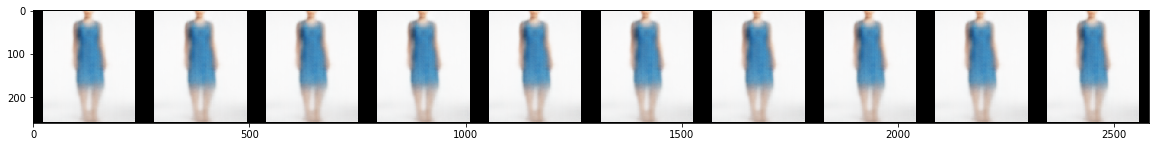

In [93]:
# Plot a grid of some traversals
traversals = viz2.latent_traversal_grid2(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(20, 20),first_n=10)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/256/cj1_256_e50maybe_b64_c10d10-10-10_gam30_traversals3000.png",dpi=200)

In [ ]:
!ls

### Save Model

In [ ]:
torch.save(model.state_dict(),"trained_models/" + "statedict_" + model_name) # save state dict
#torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls